# Statistical Analysis
![analysis_plan](analysis_plan.png)


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data PreProcessing was done in the previous notebook.
See [`queryFromRequests.ipynb`](queryFromRequests.ipynb) for the data preprocessing.

## Methodology

###  Step 1: Sentiment Analysis
- See [`sentiment_analysis.ipynb`](sentiment_analysis.ipynb) for the use of the transformer model to calculate sentiment and EDA
- Results in datasets:
    - Barbie: [`barbie_reviews_sentiment.csv`](barbie_reviews_sentiment.csv)
    - Oppenheimer: [`oppenheimer_reviews_sentiment.csv`](oppenheimer_reviews_sentiment.csv)

### Step 2: Two Sample Proportion Test

**Part A: Formulate  Hypotheses**
- *Null Hypothesis (H0):* The proportion of audience approval for "Barbie" ($p_{Barbie}$) is equal to or less than the proportion of audience approval for "Oppenheimer" ($p_{Oppenheimer}$).
  
  $H0: p_{Barbie} \leq p_{Oppenheimer}$

- *Alternative Hypothesis (Ha):* The proportion of audience approval for "Barbie" is greater than the proportion for "Oppenheimer."
  
  $Ha: p_{Barbie} > p_{Oppenheimer}$

**Part B: Collect Data**

Extract the relevant data from the datasets provided. This involves aggregating the number of positive reviews and the total number of reviews for each movie.

1. Calculate the proportion of positive reviews for "Barbie."
2. Calculate the proportion of positive reviews for "Oppenheimer."

In [9]:
barbie_df = pd.read_csv('barbie_reviews_sentiment.csv')
oppenheimer_df = pd.read_csv('oppenheimer_reviews_sentiment.csv')

# proportion of positive reviews for "Barbie"
barbie_positive = barbie_df[barbie_df['sentiment'] == 'POSITIVE']
barbie_positive_proportion = len(barbie_positive)/len(barbie_df)
print('Proportion of positive reviews for Barbie: ', barbie_positive_proportion)

# proportion of positive reviews for "Oppenheimer"
oppenheimer_positive = oppenheimer_df[oppenheimer_df['sentiment'] == 'POSITIVE']
oppenheimer_positive_proportion = len(oppenheimer_positive)/len(oppenheimer_df)
print('Proportion of positive reviews for Oppenheimer: ', oppenheimer_positive_proportion)

Proportion of positive reviews for Barbie:  0.7122153209109731
Proportion of positive reviews for Oppenheimer:  0.7323943661971831


**Part C: Perform the Two-Sample Z-Test**

To conduct the two-sample z-test, we will use the proportions calculated in Step 3 to:

1. Compute the test statistic based on the difference in proportions.
2. Determine the standard error of the difference in proportions.
3. Calculate the z-score.
4. Use the z-score to find the p-value from the z-distribution.

The formula for the test statistic (z) is given by:

$$z = \frac{(\hat{p}_{Barbie} - \hat{p}_{Oppenheimer})}{\sqrt{P(1-P)\left(\frac{1}{n_{Barbie}} + \frac{1}{n_{Oppenheimer}}\right)}}$$

where:
- $\hat{p}_{Barbie}$ and $\hat{p}_{Oppenheimer}$ are the sample proportions of positive reviews for "Barbie" and "Oppenheimer," respectively.
- $P$ is the pooled proportion of positive reviews from both movies, calculated as $\frac{x_{Barbie} + x_{Oppenheimer}}{n_{Barbie} + n_{Oppenheimer}}$, where $x$ represents the number of positive reviews and $n$ the total number of reviews.
- $n_{Barbie}$ and $n_{Oppenheimer}$ are the total number of reviews for each movie.


In [10]:
z_statistic = (barbie_positive_proportion - oppenheimer_positive_proportion) / np.sqrt(
    (barbie_positive_proportion*(1-barbie_positive_proportion)/len(barbie_df)) + (oppenheimer_positive_proportion*(1-oppenheimer_positive_proportion)/len(oppenheimer_df))
    )
print('Z-statistic: ', z_statistic)

Z-statistic:  -0.705238079142905


**Part D: Conclusion**

Based on the p-value obtained from the z-score:

- If the p-value is less than the significance level (typically 0.05), we reject the null hypothesis, suggesting that the proportion of audience approval for "Barbie" is significantly greater than that for "Oppenheimer."
- If the p-value is greater than the significance level, we fail to reject the null hypothesis, indicating no significant difference in the audience approval rates as per our initial comparison criteria.

In [11]:
# p-value
from scipy.stats import norm
p_value = 1 - norm.cdf(z_statistic)
print('P-value: ', round(p_value, 4))
if p_value < 0.05:
    print('We reject the null hypothesis suggesting that the proportion of audience approval for  "Barbie" is significantly greater from the proportion of audience approval for "Oppenheimer"')
else:
    print('Fail to reject the null hypothesis indicating that the proportion of audience approval for  "Barbie" is not significantly greater from the proportion of audience approval for "Oppenheimer"')

P-value:  0.7597
Fail to reject the null hypothesis indicating that the proportion of audience approval for  "Barbie" is not significantly greater from the proportion of audience approval for "Oppenheimer"


### Step 3: Permutation Analysis
**Part A: Preprocessing**
- Combine [`barbie_reviews_sentiment.csv`](barbie_reviews_sentiment.csv) and [`oppenheimer_reviews_sentiment.csv`](oppenheimer_reviews_sentiment.csv) with labels to which movie the review belongs to

In [12]:
# label all rows in the barbie dataframe with "barbie" in column `movie_name`
barbie_df['movie_name'] = 'barbie'
# label all rows in the oppenheimer dataframe with "oppenheimer" in column `movie_name`
oppenheimer_df['movie_name'] = 'oppenheimer'

# combine the two dataframes
combined_df = pd.concat([barbie_df, oppenheimer_df])

**Part B: Random Permutations**
- For each of the 1000 iterations, randomly assign reviews to movie
- Calculate z-score for the permutation
- calculate p-valule
- Add to dataframe to create null distribution

In [15]:

# Preallocate space for z-statistics and p-values
results = np.zeros((1000, 2))

for i in range(1000):
    # Randomly permute the 'movie_name' column
    shuffled_movie_names = np.random.permutation(combined_df['movie_name'].values)
    
    # Calculate proportions of positive reviews for each movie after shuffling
    for movie in ['barbie', 'oppenheimer']:
        movie_mask = shuffled_movie_names == movie
        sentiment_mask = combined_df['sentiment'].values == 'POSITIVE'
        
        positive_proportion = np.sum(movie_mask & sentiment_mask) / np.sum(movie_mask)
        
        if movie == 'barbie':
            barbie_positive_proportion_new = positive_proportion
        else:
            oppenheimer_positive_proportion_new = positive_proportion
    
    # Calculate the z-statistic
    z_statistic_new = (barbie_positive_proportion_new - oppenheimer_positive_proportion_new) / np.sqrt(
        (barbie_positive_proportion_new * (1 - barbie_positive_proportion_new) / np.sum(shuffled_movie_names == 'barbie')) + 
        (oppenheimer_positive_proportion_new * (1 - oppenheimer_positive_proportion_new) / np.sum(shuffled_movie_names == 'oppenheimer'))
    )
    
    # Calculate the p-value
    p_value_new = 1 - norm.cdf(z_statistic_new)
    
    # Store the results
    results[i, :] = [z_statistic_new, p_value_new]

# Convert results to a DataFrame
null_distribution_df = pd.DataFrame(results, columns=['z_statistic', 'p_value'])

null_distribution_df



,z_statistic,p_value
0,1.580861,0.056955
1,-0.277198,0.609186
2,-1.276358,0.899085
3,0.293581,0.384539
4,0.436345,0.331293
...,...,...
995,-0.847957,0.801769
996,0.722020,0.235141
997,-1.419268,0.922090
998,0.436345,0.331293


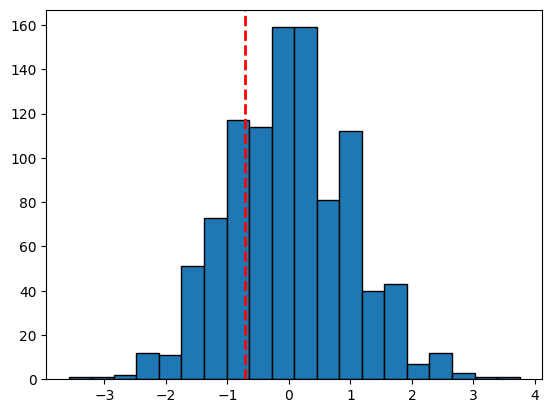

In [16]:
# plot the null distribution
plt.hist(null_distribution_df['z_statistic'], bins=20, edgecolor='black')
# plot the observed z-statistic
plt.axvline(z_statistic, color='red', linestyle='dashed', linewidth=2)